In [1]:
import geopandas as gpd

hm = gpd.read_parquet('../data/processed_datasets/health-monitoring_2007-2023_EPSG4326_FR.parquet').to_crs('epsg:32631')
#change the nfi class str 'Drought' to 'Drought-dieback'


In [2]:
hm



,year,geometry,LIB_Problème principal,Remarques,class,essence,tree_type
10,2007,POINT (33458.912 5346668.080),Puceron vert de l'épicéa,Attaque de pucerons sévère sur l'ensemble du s...,biotic-factor,Spruces,conifer
17,2007,POINT (826720.508 4900762.541),Tordeuse verte du chêne,nan,biotic-factor,Oaks,broadleaf
27,2007,POINT (498448.744 5083648.170),Typographe,proche suivi intensif attaque antérieure sur l...,biotic-factor,Spruces,conifer
28,2007,POINT (498448.744 5083648.170),Typographe,proche suivi intensif attaque antérieure sur l...,biotic-factor,Spruces,conifer
36,2007,POINT (540758.865 5041495.290),Gui,"Sur les très gros bois, impact très fort Stati...",biotic-factor,Firs,conifer
...,...,...,...,...,...,...,...
73300,2023,POINT (278420.495 4894390.384),Sténographe,Futaie régulière de pin maritime 35-39 ans pré...,biotic-factor,Pines,conifer
73301,2023,POINT (278420.495 4894390.384),Sténographe,Futaie régulière de pin maritime 35-39 ans pré...,biotic-factor,Pines,conifer
73302,2023,POINT (784601.545 4874117.334),Mineuse des aiguilles du sapin,La mineuse c'est étendu a tous les sapins de c...,biotic-factor,Firs,conifer
73303,2023,POINT (358532.385 5358020.722),Collybie à pied en fuseau,nan,biotic-factor,Oaks,broadleaf


In [3]:
from shapely import wkt
import pandas as pd
import geopandas as gpd


# Load the CSV data
# Parse the 'geometry' column to extract longitude and latitude
hm['longitude'] = hm['geometry'].apply(lambda geom: geom.x)
hm['latitude'] = hm['geometry'].apply(lambda geom: geom.y)

# Set class names
class_names = hm['class'].unique()

# Load the data with GeoPandas
gdf = gpd.GeoDataFrame(
    hm, 
    geometry=gpd.points_from_xy(hm.longitude, hm.latitude),
    crs="EPSG:32631"  # Set the CRS to 'epsg:32631'
)



/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [4]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math

# Define a function to convert Web Mercator to lat/lon
def web_mercator_to_lat_lon(val, pos=None, is_lat=True):
    if is_lat:
        return "{:.2f}°".format(math.degrees(2 * math.atan(math.exp(val / 6378137.0)) - math.pi/2))
    else:
        return "{:.2f}°".format(val / (6378137.0) * 57.2957795)


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


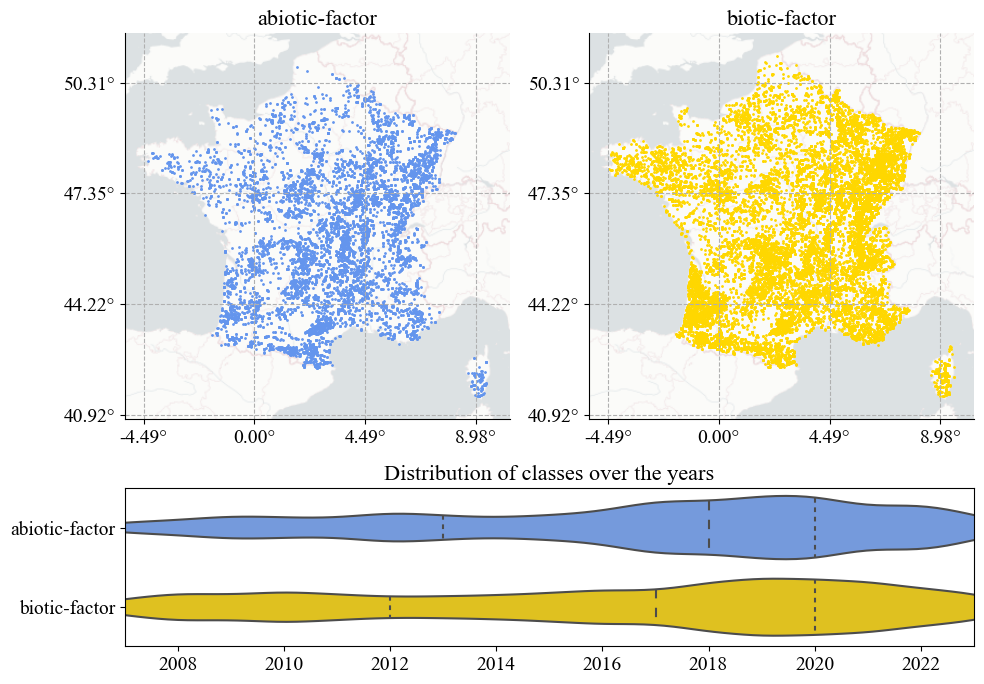

In [17]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
from utils import pol_from_points
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math

# Set global font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Set global font size
plt.rcParams['font.size'] = 12  # Adjust as needed

# Additional font size settings
plt.rcParams['axes.labelsize'] = 14  # Font size for x and y labels
plt.rcParams['axes.titlesize'] = 16  # Font size for subplot titles
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels


# Setup the figure and axes using GridSpec
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(3, 4, figure=fig)

# Define colors for each class
custom_color_mapping = {
    'biotic-factor': 'gold',
    'abiotic-factor': 'cornflowerblue',
  # Light blue/grey
}

gdf['year'] = gdf['year'].astype(int)
gdf_web_mercator = gdf.to_crs(epsg=3857)
minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(50000).total_bounds
#build GeoDataFrame from the bounds
df = gpd.GeoDataFrame({'geometry': pol_from_points((minx, miny, maxx, maxy))}, index=[0], crs='epsg:3857')

# Plot point clouds for each class in the first two rows
for idx, class_name in enumerate(sorted(class_names)):
    row = 0
    col = idx 
    ax = fig.add_subplot(gs[:2, idx*2:(idx+1)*2])
    
    df.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
    gdf_web_mercator[gdf_web_mercator['class'] == class_name].plot(ax=ax, color=custom_color_mapping[class_name], markersize=1, alpha=1)
    
    # Adding basemap with contextily
    # cx.add_basemap(ax, crs=gdf_web_mercator.crs.to_string(), attribution=False, source=cx.providers.Esri.WorldShadedRelief)
    cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.CartoDB.PositronNoLabels, zoom=5, alpha=.8)
    ax.set_title(class_name)
    # ax.set_xlabel('Longitude')
    # ax.set_ylabel('Latitude')
    ax.axis('equal')
    
    ax.grid(True, linestyle='--')  # Add grid

    # Setting the same extents for all plots
    ax.set_xlim((minx, maxx))
    ax.set_ylim((miny, maxy))
        
    # Using MultipleLocator to set tick locations
    ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
    ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))

    # Using FuncFormatter to convert tick labels to lat/lon
    ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
    ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


# Plot violin plots in the third row spanning all columns with normalized width
ax_violin = fig.add_subplot(gs[2, :])
sns.violinplot(x='year', y='class', data=gdf, ax=ax_violin, order=sorted(class_names),
               palette=custom_color_mapping, inner="quart", density_norm='width')
ax_violin.set_title('Distribution of classes over the years')
ax_violin.set_ylabel(None)
ax_violin.set_xlabel(None)
ax_violin.set_xlim((2007, 2023))
plt.tight_layout()
plt.show()


In [18]:
dpi = 200 
fig.savefig(f'../figures/HM_2007-2023_EPSG3857_FR_dpi{dpi}.png', dpi=dpi, bbox_inches='tight')

SyntaxError: invalid syntax (1056758223.py, line 1)